In [1]:
using Revise

In [2]:
using OpticalBlochEquations, QuantumStates

┌ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]
└ @ Base loading.jl:1423
┌ Info: Precompiling QuantumStates [17f0441f-15e0-42ae-a101-302633ff8f0f]
└ @ Base loading.jl:1423


In [17]:
using Plots
using BenchmarkTools
using DifferentialEquations
using LinearAlgebra

### Construct the $\text{X}^2\Sigma^+(N = 1)$ state in Hund's case (b) basis

In [18]:
# Spectroscopic constants for CaF, X state

# From Luke Caldwell's thesis (2020)
# Units are MHz
Be_X = 10303.988 #10267.5387
De_X = 0.014060
γSR_X = 39.65891
b_X = 109.1839
c_X = 40.1190

# Be_X = 10267.3963
# γSR_X = 39.498076
# bF_X = 108.475273
# cF_X = 40.6471
;

In [19]:
QN_bounds = (S = 1//2, I = 1//2, Λ = -1:1, N = 0:3)
basis_X = enumerate_states(HundsCaseB_Rot, QN_bounds)
ordered_basis_X = order(basis_X, :M)
;

In [20]:
H_X_operator = 
    Be_X * Rotation + 
    De_X * RotationDistortion + 
    γSR_X * SpinRotation + 
    (b_X + c_X/3) * Hyperfine_IS + 
    (c_X/3) * Hyperfine_Dipolar
;

In [21]:
H_X = Hamiltonian(basis=ordered_basis_X, H_operator=H_X_operator)
update_matrix!(H_X)
es_X, vs_X = eigen(H_X.M)
states_X = states_from_basis(ordered_basis_X, es_X, vs_X)
;

In [22]:
states_X_N1 = subspace(states_X, (Λ = 0, N = 1,))
;

### Construct $\text{A}^2 \Pi_{1/2}(J' = 1/2, \text{parity} = e)$ state in Hund's case (a) basis

In [23]:
# Spectroscopic constants for CaF, A state
# From Kaledin et al. (1998)
T_A = 16526.750 * c * 1e-4
Be_A = 0.34248818 * c * 1e-4
Aso_A = 71.429 * c * 1e-4
b00_A = -4.8
p_A = -1334.6
q_A = -8.742
;

In [24]:
QN_bounds = (S = 1/2, I = 1/2, Λ = [-1, 1], J = 1/2:3/2)
basis_A = enumerate_states(HundsCaseA_Rot, QN_bounds)
ordered_basis_A = order(basis_A, :M)
;

In [25]:
H_A_operator = 
    T_A * DiagonalOperator +
    Be_A * Rotation + 
    Aso_A * SpinOrbit + 
    q_A * ΛDoubling_q +
    (p_A + 2q_A) * ΛDoubling_p2q +
    b00_A * (Hyperfine_IF - Hyperfine_IL)
;

In [26]:
H_A = Hamiltonian(basis=ordered_basis_A, H_operator=H_A_operator)
update_matrix!(H_A)
es_A, vs_A = eigen(H_A.M)
states_A = states_from_basis(ordered_basis_A, es_A, vs_A)
;

In [27]:
states_A_J12 = subspace(states_A, (J = 1/2,))

# Pick out only the states of positive parity
states_A_J12 = states_A_J12[5:8]
;

In [28]:
states_A_J12_caseB = convert_basis(states_A_J12, ordered_basis_X)
;

In [29]:
states = [states_X_N1; states_A_J12_caseB]
;

### Calculate transition dipole moments between the two states

In [32]:
d = zeros(length(states), length(states), 3)
for (i, X_state) in enumerate(states)
    for (j, A_state) in enumerate(states)
        for p in -1:1
            d[i,j,p+2] = round(TDM(X_state, A_state, p), digits=10)
        end
    end
end
;

In [33]:
# In TMD, states are ordered as
# Ground states:
# F = 1-, M = -1
# F = 1-, M = 0
# F = 1-, M = 1
# F = 0, M = 0
# F = 1+, M = 0
# F = 1+, M = -1
# F = 1+, M = 1
# F = 2, M = 1
# F = 2, M = -2
# F = 2, M = 2
# F = 2, M = -1
# F = 2, M = 0

# Excited states:
# F = 0, M = 0
# F = 1, M = 1
# F = 1, M = 0
# F = 1, M = -1

In [34]:
const λ = @with_unit 606.3 "nm"
const Γ = @with_unit 2π * 8.3 "MHz"
const M = @with_unit 50 "u"
const E₀ = c / λ
const ω = 2π * E₀
const k = ω / c
;

In [35]:
# Generate ground states
# ω1 = 2π * @with_unit -2.90 "MHz"
# ω2 = 2π * @with_unit 24.15 "MHz"
# ω3 = 2π * @with_unit 72.29 "MHz"
# ω4 = 2π * @with_unit 146.00 "MHz"

ω_g1 = 2π * @with_unit 0.0 "MHz"
ω_g2 = 2π * @with_unit 76.0 "MHz"
ω_g3 = 2π * @with_unit 123.0 "MHz"
ω_g4 = 2π * @with_unit 148.00 "MHz"

g1 = manifold(F=1, ω=ω_g1, μ=0)
g2 = manifold(F=0, ω=ω_g2, μ=0)
g3 = manifold(F=1, ω=ω_g3, μ=0)
g4 = manifold(F=2, ω=ω_g4, μ=0)
ground_states = collect(Iterators.flatten([g.states for g in [g1, g2, g3, g4]]))

ordering = [2,1,3,4,6,5,7,10,11,12,9,8]
ground_states = ground_states[ordering]

# Generate excited states
ω_e1 = 2π * (E₀ - @with_unit 5 "MHz")
ω_e2 = 2π * E₀
e1 = manifold(F=0, ω=ω_e1, μ=0, Γ=Γ)
e2 = manifold(F=1, ω=ω_e2, μ=0, Γ=Γ)
excited_states = collect(Iterators.flatten([e.states for e in [e1, e2]]))

ordering = [3,4,2,1]
excited_states = excited_states[ordering]
;

In [36]:
d = zeros(length(states), length(states), 3)
;

In [37]:
d = zeros(16, 16, 3)
d[1:12,13:16,1] .= round.((states_X_a.states' * TDM_Matrix[:,:,1] * states_A.states), digits=10)[5:16,:]
d[1:12,13:16,2] .= round.((states_X_a.states' * TDM_Matrix[:,:,2] * states_A.states), digits=10)[5:16,:]
d[1:12,13:16,3] .= round.((states_X_a.states' * TDM_Matrix[:,:,3] * states_A.states), digits=10)[5:16,:]

d[13:16,1:12,1] .= round.((states_X_a.states' * TDM_Matrix[:,:,1] * states_A.states), digits=10)[5:16,:]'
d[13:16,1:12,2] .= round.((states_X_a.states' * TDM_Matrix[:,:,2] * states_A.states), digits=10)[5:16,:]'
d[13:16,1:12,3] .= round.((states_X_a.states' * TDM_Matrix[:,:,3] * states_A.states), digits=10)[5:16,:]'
;

LoadError: UndefVarError: states_X_a not defined

In [436]:
# Wigner D-matrix to rotate polarization vector
D(cosβ, sinβ, α, γ) = [
    (1/2)*(1 + cosβ)*exp(-im*(α + γ)) -(1/√2)*sinβ*exp(-im*α) (1/2)*(1 - cosβ)*exp(-im*(α - γ));
    (1/√2)*sinβ*exp(-im*γ) cosβ -(1/√2)*sinβ*exp(im*γ);
    (1/2)*(1 - cosβ)*exp(im*(α - γ)) (1/√2)*sinβ*exp(im*α) (1/2)*(1 + cosβ)*exp(im*(α + γ))
]

function rotate_pol(pol, k)
    # Rotates polarization `pol` onto the quantization axis `k`
    k = k / norm(k)
    cosβ = k[3]
    sinβ = sqrt(1 - cosβ^2)
    α = 0.0
    if abs(cosβ) < 1
        γ = atan(k[2], k[1])
    else
        γ = 0.0
    end
    return inv(D(cosβ, sinβ, α, γ)) * pol
end;

In [437]:
function find_idx_for_time(time_to_find, times, backwards)
    if backwards
        times = reverse(times)
    end
    start_time = times[1]
    found_idx = 0
    for (i, time) in enumerate(times)
        if abs(start_time - time) > time_to_find
            found_idx = i
            break
        end
    end
    if backwards
        found_idx = length(times) + 1 - found_idx
    end
    
    return found_idx
end;

In [438]:
function calculate_force_from_period(p, sol, force_idxs)
    """
    Integrates the force resulting from `sol` over a time period designated by `period`.
    """
    force = 0.0
    for i in force_idxs
        force += OpticalBlochEquations.force(p, sol.u[i], sol.t[i])
    end
    t = sol.t[force_idxs[end]] - sol.t[force_idxs[1]]
    return force / (length(force_idxs))
end;

In [439]:
Is = 4.9; # saturation intensity for CaF X-A transition, in mW/cm^2

In [440]:
# Multi-frequency scheme
δf = @with_unit 2π * 20 "MHz"

s = 117 / Is / 24 # Divide by number of lasers

# Generate lasers
x = [1., 0, 0]
y = [0., 1, 0]
z = [0., 0, 1]

σ_m = [1., 0., 0.]
σ_p = [0., 0., 1.]

θ1 = 0
θ2 = 0

ω0 = states[13].ω # Frequency from E = 0 to F = 2

f1 = ω0 - ω1 + δf # Transition is ω0 minus F = 1- position
f2 = ω0 - ω2 + δf # Transition is ω0 minus F = 0 position
f3 = ω0 - ω3 + δf # Transition is ω0 minus F = 1+ position
f4 = ω0 - ω4 + δf # Transition is ω0 minus F = 2 position

σ1 = σ_m
σ2 = σ_m
σ3 = σ_p
σ4 = σ_m

l1 = Laser(-x, rotate_pol(σ1, -x), f1, s)
l2 = Laser( x, rotate_pol(σ1,  x), f1, s)

l3 = Laser(-y, rotate_pol(σ1, -y), f1, s)
l4 = Laser( y, rotate_pol(σ1,  y), f1, s)

l5 = Laser(-z, rotate_pol(σ1, -z), f1, s)
l6 = Laser( z, rotate_pol(σ1,  z), f1, s)

l7 = Laser(-x, rotate_pol(σ2, -x), f2, s)
l8 = Laser( x, rotate_pol(σ2,  x), f2, s)

l9 = Laser(-y, rotate_pol(σ2, -y), f2, s)
l10 = Laser( y, rotate_pol(σ2,  y), f2, s)

l11 = Laser(-z, rotate_pol(σ2, -z), f2, s)
l12 = Laser( z, rotate_pol(σ2,  z), f2, s)

l13 = Laser(-x, rotate_pol(σ3, -x), f3, s)
l14 = Laser( x, rotate_pol(σ3,  x), f3, s)

l15 = Laser(-y, rotate_pol(σ3, -y), f3, s)
l16 = Laser( y, rotate_pol(σ3,  y), f3, s)

l17 = Laser(-z, rotate_pol(σ3, -z), f3, s)
l18 = Laser( z, rotate_pol(σ3,  z), f3, s)

l19 = Laser(-x, rotate_pol(σ4, -x), f4, s)
l20 = Laser( x, rotate_pol(σ4,  x), f4, s)

l21 = Laser(-y, rotate_pol(σ4, -y), f4, s)
l22 = Laser( y, rotate_pol(σ4,  y), f4, s)

l23 = Laser(-z, rotate_pol(σ4, -z), f4, s)
l24 = Laser( z, rotate_pol(σ4,  z), f4, s)

multi_lasers = [l1, l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12,
    l13, l14, l15, l16, l17, l18, l19, l20, l21, l22, l23, l24]
;

In [441]:
# Λ-cooling
# Scheme "(II)" in "Deep laser cooling and efficient magnetic compression of molecules (Caldwell, 2019)"
Is = 4.9

δf = @with_unit 2π * 30 "MHz"
s = 50 / Is / 12 # Divide by number of lasers

# Generate lasers
x = [1., 0, 0]
y = [0., 1, 0]
z = [0., 0, 1]

σ_m = [1., 0., 0.]
σ_p = [0., 0., 1.]

ω0 = (states[13].ω - states[1].ω) # Frequency from F = -1 to F = 1
ω1 = (states[13].ω - states[12].ω) # Frequency from F = 2 to F = 1

det_F1 = ω0 + δf
det_F2 = ω1 + δf

l1 = Laser(-x, rotate_pol(σ_m, -x), det_F1, s)
l2 = Laser( x, rotate_pol(σ_m,  x), det_F1, s)

l3 = Laser(-y, rotate_pol(σ_m, -y), det_F1, s)
l4 = Laser( y, rotate_pol(σ_m,  y), det_F1, s)

l5 = Laser(-z, rotate_pol(σ_m, -z), det_F1, s)
l6 = Laser( z, rotate_pol(σ_m,  z), det_F1, s)

l7 = Laser(-x, rotate_pol(σ_m, -x), det_F2, s)
l8 = Laser( x, rotate_pol(σ_m,  x), det_F2, s)

l9 = Laser(-y, rotate_pol(σ_m, -y), det_F2, s)
l10 = Laser( y, rotate_pol(σ_m,  y), det_F2, s)

l11 = Laser(-z, rotate_pol(σ_m, -z), det_F2, s)
l12 = Laser( z, rotate_pol(σ_m,  z), det_F2, s)

Λ_lasers = [l1, l2, l3, l4, l5, l6, l7, l8, l9, l10, l11, l12]
;

In [786]:
# Single-frequency cooling
# Scheme "(III)" in "Deep laser cooling and efficient magnetic compression of molecules (Caldwell, 2019)"
Is = 4.9

δf = +Γ
s = 10 * 340 / Is / 6 # Divide by number of lasers

# Generate lasers
x = [1., 0, 0]
y = [0., 1, 0]
z = [0., 0, 1]

σ_m = [1., 0., 0.]
σ_p = [0., 0., 1.]

θ1 = 0
θ2 = 0

f = (ω_e2 - ω_g1) + δf

l1 = Laser(-x, rotate_pol(σ_p, -x), f, s)
l2 = Laser(+x, rotate_pol(σ_p, +x), f, s)

l3 = Laser(-y, rotate_pol(σ_p, -y), f, s)
l4 = Laser(+y, rotate_pol(σ_p, +y), f, s)

l5 = Laser(-z, rotate_pol(σ_p, -z), f, s)
l6 = Laser(+z, rotate_pol(σ_p, +z), f, s)

SF_lasers = [l1, l2, l3, l4, l5, l6]
;

In [788]:
lasers = SF_lasers;
# lasers = Λ_lasers;
# lasers = multi_lasers;

In [789]:
using StaticArrays

ρ0 = zeros(ComplexF64, length(states), length(states))
ρ0[1,1] = 1.0

# Frequencies are rounded to a multiple of `freq_res`, and are measured in units of Γ
freq_res = 1e-3

(dρ, ρ, p) = obe(states, lasers, d, ρ0, freq_res=freq_res)
ρ!(dρ, ρ, p, 0.0)

ω_min = freq_res
period = 2π / ω_min
display(period)

6283.185307179586

In [790]:
# @btime ρ!($dρ, $ρ, $p, $1.0)

In [793]:
t_end = 2π * 2000
tspan = (0., t_end)
times = range(tspan[1], tspan[2], 200000)

p.particle.r0 = SVector(0., 0., 0.) 
p.particle.v = SVector(0., 0., 1.5) / (Γ / k)
p.particle.v = round_vel(p.particle.v, λ, Γ, freq_res)
println(p.particle.v * (Γ / k))

prob = ODEProblem(ρ!, ρ0, tspan, p, callback=AutoAbstol(false, init_curmax=0.0))

# @time sol = solve(prob, alg=DP5(), abstol=1e-6, reltol=1e-3, dense=false, saveat=times)
@time sol = solve(prob, alg=DP5(), abstol=1e-6, reltol=1e-7, dense=false, saveat=times)
;

[0.0, 0.0, 1.4941126160019003]
 12.230050 seconds (556.01 k allocations: 1.516 GiB, 22.35% gc time)


In [794]:
offset = 100
period_idx = find_idx_for_time(period, sol.t, true)
force_idxs = (period_idx - offset):(length(times) - offset)
force = calculate_force_from_period(p, sol, force_idxs)

println("Excited population: ", real(sum(diag(mean(sol.u[force_idxs]))[13:end])))
println("Force: ", force)
println("Acceleration (10^3 m/s^2): ", 10^(-3) * ħ * k * Γ * force / M)

Excited population: 0.03564984105233735
Force: -0.001181624166821645
Acceleration (10^3 m/s^2): -0.8111229411409041


In [737]:
diag(sol.u[end-offset].^2 - sol.u[period_idx-offset].^2) |> sum

0.0014559248343294071 + 0.0im

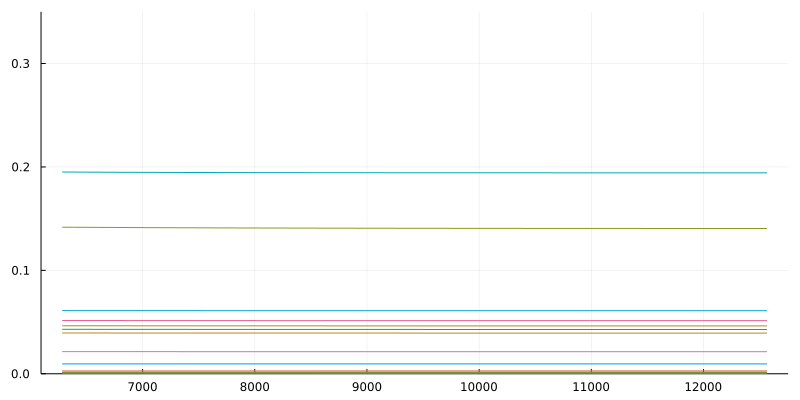

In [738]:
idxs_to_plot = force_idxs[1:100:end]
plot_us = sol.u[idxs_to_plot]
plot_ts = sol.t[idxs_to_plot]

plot(plot_ts, [real(u[1,1]) for u in plot_us], size=(800, 400), ylim=(0, 0.35))
for i in 2:16
    plot!(plot_ts, [real(u[i,i]) for u in plot_us])
end
plot!(legend=nothing)

In [524]:
vs = collect(0.0:0.2:1.0)
forces = zeros(length(vs))
exc_pop = zeros(length(vs))

t_end = 2π * 2000
tspan = (0., t_end)
times = range(tspan[1], tspan[2], 200000)

freq_res = 1e-3
ω_min = freq_res
period = 2π / ω_min

@time begin
    Threads.@threads for i in 1:length(vs)
        
        v = vs[i]
        
        p_ = deepcopy(p)
        
        p_.particle.r0 = SVector(0., 0., 0.)
        p_.particle.v = SVector(0.0, 0.0, v)
        p_.particle.v = round_vel(p_.particle.v * (Γ / k), λ, Γ, freq_res)
        
        vs[i] = sqrt(sum(p_.particle.v.^2)) / (Γ / k)
        
        ρ0 = zeros(ComplexF64,(16,16))
        ρ0[1,1] = 1.0

        prob = ODEProblem(ρ!, ρ0, tspan, p_)
        sol = solve(prob, alg=DP5(), abstol=1e-6, reltol=1e-7, dense=false, saveat=times)

        offset = 0
        period_idx = find_idx_for_time(period, sol.t, true)
        force_idxs = (period_idx - offset):(length(times) - offset)
        
        force = calculate_force_from_period(p_, sol, force_idxs)

        forces[i] = force
        exc_pop[i] = real(sum(diag(mean(sol.u[force_idxs]))[13:end]))
            
    end
end
forces_SI = (10^(-3) * ħ * k * Γ * forces / M)
;

 34.948830 seconds (1.91 M allocations: 7.146 GiB, 0.76% gc time, 0.16% compilation time)


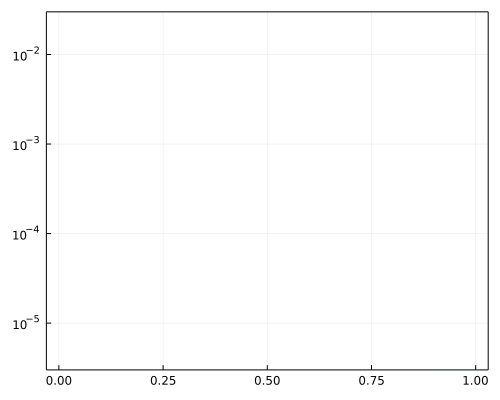

In [525]:
plot(vs, exc_pop, 
    size=(500, 400), 
    legend=nothing, 
    yaxis=:log, 
    ylims=(3e-6, 3e-2), 
    yticks=[1e-5, 1e-4, 1e-3, 1e-2],
    framestyle = :box
)

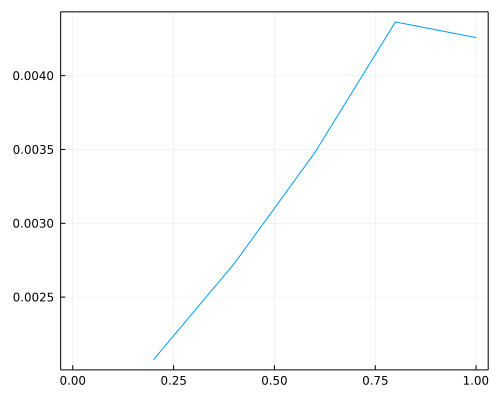

In [526]:
plot(vs, forces_SI, 
    size=(500,400), 
    legend=nothing, 
    ylim=[minimum([0; forces_SI]), maximum([0; forces_SI])],
    framestyle = :box
)